In [1]:
import tensorflow

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.layers import Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

Using TensorFlow backend.


In [3]:
tensorflow.__version__

'1.14.0'

In [4]:
keras.__version__

'2.2.4'

In [5]:
df = pd.read_csv('new_train.csv')
df.head( )

,id_code,level
0,000c1434d8d7,1
1,001639a390f0,1
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [6]:
new_df = pd.concat([df[df.level==1][0:750], df[df.level==0][0:750]])

In [7]:
new_df.shape

(1500, 2)

In [8]:
new_df.id_code = new_df.id_code.apply(lambda x: f'{x}.png')

In [9]:
new_df.head()

,id_code,level
0,000c1434d8d7.png,1
1,001639a390f0.png,1
2,0024cdab0c1e.png,1
5,0083ee8054ee.png,1
7,00a8624548a9.png,1


In [10]:
new_df.level = new_df.level.apply(lambda x: str(x))

In [11]:
seed = 100

In [12]:
tra, testdf = train_test_split(new_df, test_size=0.3, random_state=seed)

In [13]:
tra.shape

(1050, 2)

In [14]:
testdf.shape

(450, 2)

In [15]:
traindf, validdf = train_test_split(tra, test_size=0.2, random_state=seed)

In [16]:
traindf.shape

(840, 2)

In [17]:
validdf.shape

(210, 2)

In [18]:
testdf.level.value_counts()

1    230
0    220
Name: level, dtype: int64

In [19]:
traindf.level.value_counts()

0    423
1    417
Name: level, dtype: int64

In [20]:
validdf.level.value_counts()

0    107
1    103
Name: level, dtype: int64

In [21]:
batch_size=10

In [22]:
datagen = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input)

In [23]:
train_data = datagen.flow_from_dataframe(traindf, directory='cropped/', x_col='id_code', y_col='level', target_size=(224,224), batch_size=batch_size)

Found 840 validated image filenames belonging to 2 classes.


In [24]:
valid_data = datagen.flow_from_dataframe(validdf, directory='cropped/', x_col='id_code', y_col='level', target_size=(224,224), batch_size=batch_size)

Found 210 validated image filenames belonging to 2 classes.


In [51]:
test_data = datagen.flow_from_dataframe(testdf, directory='cropped/', x_col='id_code', y_col=None, target_size=(224,224), class_mode=None
                                        , classes=None, batch_size=batch_size, shuffle=False)

Found 450 validated image filenames.


In [52]:
# datagen.flow_from_dataframe

In [26]:
mobile = keras.applications.mobilenet.MobileNet()
mobile.summary()

W0217 02:12:19.169350 16640 deprecation_wrapper.py:119] From E:\c\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0217 02:12:19.189296 16640 deprecation_wrapper.py:119] From E:\c\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0217 02:12:19.196306 16640 deprecation_wrapper.py:119] From E:\c\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0217 02:12:19.234177 16640 deprecation_wrapper.py:119] From E:\c\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0217 02:12:19.235175 16640 deprecation_wrapper.py:119] From E:\c\envs\t

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [27]:
x = mobile.layers[-6].output
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=mobile.input, outputs=predictions)

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [29]:
for layer in model.layers[:-28]:
    layer.trainable = False

In [30]:
# model.summary()

In [31]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

W0217 02:12:46.868244 16640 deprecation_wrapper.py:119] From E:\c\envs\tensorflow\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [32]:
train_steps = traindf.shape[0]//batch_size
valid_steps = validdf.shape[0]//batch_size
test_steps = testdf.shape[0]//batch_size

In [33]:
model.fit_generator(train_data, steps_per_epoch=train_steps, validation_data=valid_data, validation_steps=valid_steps, epochs=60, verbose=2)

W0217 02:12:49.149048 16640 deprecation.py:323] From E:\c\envs\tensorflow\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/60
 - 113s - loss: 0.2566 - acc: 0.8976 - val_loss: 1.0747 - val_acc: 0.5524
Epoch 2/60
 - 85s - loss: 0.1095 - acc: 0.9583 - val_loss: 1.3763 - val_acc: 0.5429
Epoch 3/60
 - 72s - loss: 0.0439 - acc: 0.9869 - val_loss: 0.7134 - val_acc: 0.6857
Epoch 4/60
 - 72s - loss: 0.0396 - acc: 0.9929 - val_loss: 0.6458 - val_acc: 0.6905
Epoch 5/60
 - 72s - loss: 0.0326 - acc: 0.9929 - val_loss: 0.4478 - val_acc: 0.8095
Epoch 6/60
 - 72s - loss: 0.0215 - acc: 0.9964 - val_loss: 0.4236 - val_acc: 0.8143
Epoch 7/60
 - 72s - loss: 0.0448 - acc: 0.9893 - val_loss: 1.3738 - val_acc: 0.5762
Epoch 8/60
 - 73s - loss: 0.0163 - acc: 0.9988 - val_loss: 0.4086 - val_acc: 0.8429
Epoch 9/60
 - 72s - loss: 0.0193 - acc: 0.9964 - val_loss: 0.4850 - val_acc: 0.8095
Epoch 10/60
 - 72s - loss: 0.0090 - acc: 0.9988 - val_loss: 0.3226 - val_acc: 0.8857
Epoch 11/60
 - 72s - loss: 0.0359 - acc: 0.9881 - val_loss: 0.1949 - val_acc: 0.9429
Epoch 12/60
 - 73s - loss: 0.0080 - acc: 0.9976 - val_loss: 0.4772 - val_

In [53]:
pred = model.predict_generator(test_data, steps=test_steps)

In [54]:
import numpy as np

In [55]:
pred.shape

(450, 2)

In [43]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

In [69]:
ac = accuracy_score(pred.argmax(axis=1), testdf.level.apply(lambda x: int(x)))
ac

0.9333333333333333

In [70]:
cm = confusion_matrix(pred.argmax(axis=1), testdf.level.apply(lambda x: int(x)))
cm

array([[216,  26],
       [  4, 204]], dtype=int64)

In [61]:
import matplotlib.pyplot as plt

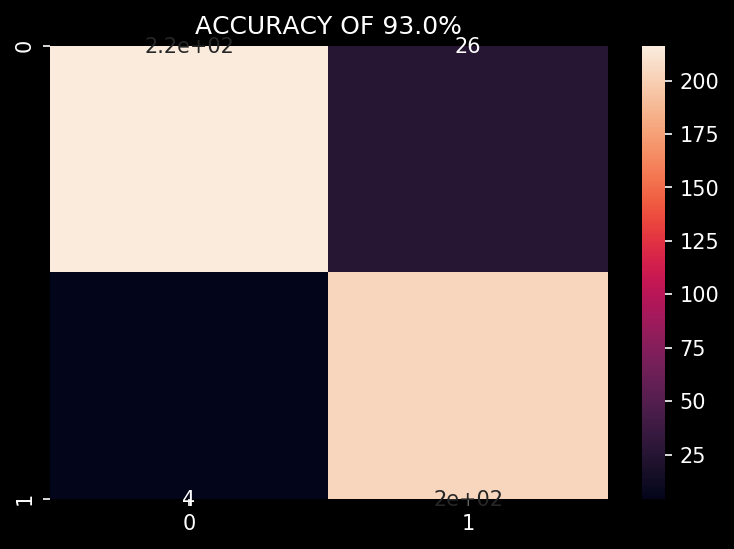

In [77]:
plt.figure(dpi=150)
plt.style.use('dark_background')
plt.title(f'ACCURACY OF {np.floor(ac*100)}%')
sns.heatmap(cm, annot=True)

### SO TRANSFER LEARNING WITH MOBILENET WORKS WITH TRAINING WITH ITS LAST 28 LAYERS AND 60 EPOCHS ACC OF (93.3%)

#### project by dani